In [1]:
import pandas as pd

In [27]:
df = pd.read_parquet('/Users/camellyc/Downloads/240203_web_ball_1.parquet')
print(df.columns)

Index(['driver', 'roi', 'animal_id', 'trial', 'frame', 'time', 'ball',
       'platform', 'activity', 'ROI_struct', 'analyze', 'L1_rest', 'L1_move',
       'L1_walk', 'L1_groom', 'L1_other', 'vel_forward', 'vel_side', 'vel_yaw',
       'L1A_rot', 'L1A_abduct', 'L1A_flex', 'L1B_flex', 'L1B_rot', 'L1C_flex',
       'L1C_rot', 'L1D_flex', 'L1A_x', 'L1A_y', 'L1A_z', 'L1B_x', 'L1B_y',
       'L1B_z', 'L1C_x', 'L1C_y', 'L1C_z', 'L1D_x', 'L1D_y', 'L1D_z', 'L1E_x',
       'L1E_y', 'L1E_z'],
      dtype='object')


In [28]:
print(df.head(100)['time'])

0     0.000000
1     0.003334
2     0.006667
3     0.010001
4     0.013334
        ...   
95    0.316684
96    0.320018
97    0.323351
98    0.326685
99    0.330018
Name: time, Length: 100, dtype: float64


In [29]:
print(df.head(100)['L1_move'])

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
95    0.0
96    0.0
97    0.0
98    0.0
99    0.0
Name: L1_move, Length: 100, dtype: float64


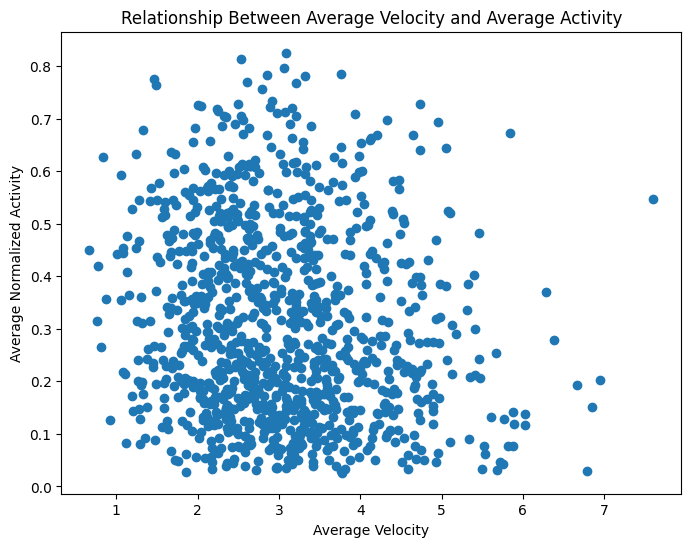

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the epoch size in frames
epoch_frame_size = 300
velocity_threshold = 0.1
consecutive_threshold_duration = 0.02  # 20 ms in seconds

# Initialize a list to store the valid epoch data
valid_epochs_list = []

# Process each trial separately
for trial_name, trial_data in df.groupby('trial'):
    # Compute normalized activity within the trial
    min_activity = trial_data['activity'].min()
    max_activity = trial_data['activity'].max()
    trial_data['normalized_activity'] = (trial_data['activity'] - min_activity) / (max_activity - min_activity)

    # Divide the trial data into epochs of 60 frames each
    for start_idx in range(0, len(trial_data), epoch_frame_size):
        # Define the data range for the current epoch
        epoch_data = trial_data.iloc[start_idx:start_idx+epoch_frame_size]

        # Check if the epoch is complete (has 60 frames)
        if len(epoch_data) == epoch_frame_size:
            # Check for the velocity condition within the epoch
            velocity_data = epoch_data['vel_forward']
            time_data = epoch_data['time']
            if not velocity_data.empty:
                # Check if velocity is not consecutively below the threshold for more than 20 ms
                consecutive_below_threshold = 0
                valid_epoch = True
                for i in range(len(velocity_data)):
                    if velocity_data.iloc[i] < velocity_threshold:
                        if i == 0 or (time_data.iloc[i] - time_data.iloc[i-1]) > consecutive_threshold_duration:
                            consecutive_below_threshold = time_data.iloc[i]
                        elif (time_data.iloc[i] - consecutive_below_threshold) > consecutive_threshold_duration:
                            valid_epoch = False
                            break
                    else:
                        consecutive_below_threshold = 0

                if valid_epoch:
                    # Calculate average velocity and activity
                    avg_velocity = velocity_data.mean()
                    avg_activity = epoch_data['normalized_activity'].mean()

                    # Append to the valid epochs list
                    valid_epochs_list.append({
                        'average_velocity': avg_velocity,
                        'average_normalized_activity': avg_activity
                    })

# Create a DataFrame from the list of valid epoch data
valid_epochs_df = pd.DataFrame(valid_epochs_list)

# Plotting the relationship between average velocity and average activity
plt.figure(figsize=(8, 6))
plt.scatter(valid_epochs_df['average_velocity'], valid_epochs_df['average_normalized_activity'])
plt.xlabel('Average Velocity')
plt.ylabel('Average Normalized Activity')
plt.title('Relationship Between Average Velocity and Average Activity')
plt.show()
